In [1]:
from fastai import *
from fastai.vision import *

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
!mkdir data
!tar zxvf cifar10.tgz -C data/

In [3]:
data_path = 'data/cifar10/'
np.random.seed(1)
data = (ImageList.from_folder(data_path)
            .split_by_folder(train='train', valid='test')
            .label_from_folder()
#            .transform(get_transforms())
#            .transform(get_transforms(), size=64)
            .transform(None, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats)
      )

# data = ImageDataBunch.from_folder(data_path, train="train", valid="test", ds_tfms=None, num_workers=0).normalize(imagenet_stats)

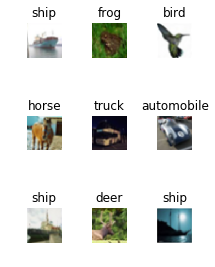

In [4]:
data.show_batch(rows=3, figsize=(3,4))

### Experiment 1
train_bn=False --> freeze the BatchNorm layers in the pretrained CNN model <br>
Disable weight decay, 1-cycle & discriminative learning rates

In [5]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], train_bn=False, wd=False, true_wd=False, bn_wd=False)
learn.fit(3)
# learn.fit(3, lr=0.0003) # this for some reasons gives different results, than when calling fit without lr

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 26.5MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.046173,0.888497,0.692900,00:57
1,0.969923,0.829589,0.709100,00:53
2,0.888620,0.817103,0.710600,00:53


### Experiment 2
train_bn=True <br>
https://forums.fast.ai/t/transfer-learning-in-fast-ai-how-does-the-magic-work/55620/21 <br>
https://forums.fast.ai/t/why-are-batchnorm-layers-set-to-trainable-in-a-frozen-model/46560/2

This achieves much better results.

In [8]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], train_bn=True, wd=False, true_wd=False, bn_wd=False)
learn.fit(3)
# learn.fit(3, lr=0.0003) # this for some reasons gives different results, than when calling fit without lr

epoch,train_loss,valid_loss,accuracy,time
0,0.555924,0.459843,0.842900,01:05
1,0.435043,0.373457,0.870000,01:06
2,0.358233,0.321294,0.890400,01:05


### Experiment 3
Don't use cnn_learner()

In [9]:
model = create_cnn_model(models.resnet50, 10, pretrained=True)
nr_layers = len(list(model.parameters()))
for param in model.parameters():
    param.requires_grad = False
    
for param in model[-1].parameters():
    param.requires_grad = True
 
# | unfreeze BatchNorm Layers
for name, param in model.named_parameters(): 
    if 'bn1' in name or 'bn2' in name or 'bn3' in name:
        param.requires_grad = True
    
learn = Learner(data, model, metrics=[accuracy], train_bn=False)

learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.462604,0.453102,0.849900,01:05
1,0.421306,0.398754,0.865700,01:05
2,0.345370,0.328008,0.892100,01:07


In [10]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 32, 32]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        False     
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
MaxPool2d            [64, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [64, 16, 16]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 16, 16]         128        True      
______________________________________________________________________
Conv2d               [64, 16, 16]         36,864     False     
___________________________________________________